In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics 
from IPython.core.display import HTML
pd.set_option("display.max_columns",75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

<p>
<span style="color:blue">
> Importing data
</span>
</p>

In [2]:
dataset=pd.read_excel("loan.xlsx")

## Data Cleaning

<p>
<span style="color:blue">
> Removed all empty columns ( these are the columns with personal data of the borrowers. These are not disclosed by the company. so we dropped them)<br>
> Target variable(Borrower is a Loan defaulter) - encoded to 0 or 1<br>
</span>
</p>

In [3]:
dataset = dataset.iloc[:,2:53]          #removing empty columns
data_with_loanstatus_sliced = dataset[(dataset['loan_status']=="Fully Paid") | (dataset['loan_status']=="Charged Off")]
di = {"Fully Paid":0, "Charged Off":1}   #converting target variable to boolean
Dataset_withBoolTarget= data_with_loanstatus_sliced.replace({"loan_status": di})

In [4]:
Dataset_withBoolTarget['loan_status'].value_counts()
print("Current shape of dataset :",Dataset_withBoolTarget.shape)
Dataset_withBoolTarget.head(3)

Current shape of dataset : (38577, 51)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,5000,5000,4975.0,36 months,0.1065,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,2011-12-01,0,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,1985-01-01,1,NaN,NaN,3,0,13648,0.837,9,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.0,0.00,0.00,2015-01-01,171.62,NaT,2016-05-01,0.0,NaN,1,INDIVIDUAL
1,2500,2500,2500.0,60 months,0.1527,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,2011-12-01,1,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,1999-04-01,5,NaN,NaN,3,0,1687,0.094,4,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,2013-04-01,119.66,NaT,2013-09-01,0.0,NaN,1,INDIVIDUAL
2,2400,2400,2400.0,36 months,0.1596,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,2011-12-01,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,2001-11-01,2,NaN,NaN,2,0,2956,0.985,10,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.0,0.00,0.00,2014-06-01,649.91,NaT,2016-05-01,0.0,NaN,1,INDIVIDUAL


In [5]:
dataset=Dataset_withBoolTarget
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (38577, 51)


<p>
<span style="color:blue">
> some more columns were dropped in the below cell. some of them are not related to our target variable and some of them are redundant. <br>
</span>
</p>

In [6]:
del_col_names = ["emp_title","url","desc","title","zip_code","addr_state","dti","delinq_2yrs","earliest_cr_line",
                 "inq_last_6mths","mths_since_last_delinq","mths_since_last_record","mths_since_last_major_derog",
                 "collections_12_mths_ex_med","last_credit_pull_d","next_pymnt_d","last_pymnt_d","initial_list_status"] #deleting some more columns
dataset = dataset.drop(labels = del_col_names, axis = 1) 
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (38577, 33)


<p>
<span style="color:blue">
> After indepth research about these rest 33 features, We selected ~11 relevant features using correlation matrix values. After few cells (in this ipython notebook), we used "RFE (Recursive Feature Elimination)" and " PCA(Principle Component Analysis)" do the actual feature selection.<br>
</span>
</p>

In [7]:
features = ['loan_amnt','funded_amnt','emp_length','annual_inc','home_ownership','grade',
            "last_pymnt_amnt", "pub_rec", "int_rate", "open_acc",'loan_status'] #'sub_grade' #selecting final features #'addr_state''tax_liens',
Final_data = dataset[features] #11 features with target var
Final_data=Final_data.dropna()
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (37544, 11)


## Data Transformation


<p>
<span style="color:blue">
> Grade - Borrower's grade given basing on his/her past history - encoded to numerical values. <br>
> home_ownership - this is feature in the dataset which had to be encoded to numerical values. <br>
> Emp_Length - this feature was not formatted properly. It has some values which was in the format like "10+years","5years"...etc. we changed them to numerical values in the below cell.
</span>
</p>

In [8]:
#Data encoding
Final_data['grade'] = Final_data['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
Final_data["home_ownership"] = Final_data["home_ownership"].map({"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1})
Final_data["emp_length"] = Final_data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
Final_data["emp_length"] = Final_data["emp_length"].apply(lambda x:int(x))
print("Current shape of dataset :",Final_data.shape)
Final_data.head()

Current shape of dataset : (37544, 11)


,loan_amnt,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
0,5000,5000,10,24000.0,5,6,171.62,0,0.1065,3,0
1,2500,2500,1,30000.0,5,5,119.66,0,0.1527,3,1
2,2400,2400,10,12252.0,5,5,649.91,0,0.1596,2,0
3,10000,10000,10,49200.0,5,5,357.48,0,0.1349,10,0
5,5000,5000,3,36000.0,5,7,161.03,0,0.0790,9,0


## Filling Missing values and Feature scaling 


<p>
<span style="color:blue">
> We have some important features which have some missing values. We filled those missing those values with the mean of the column. <br>
> We scaled the features all the features here using standard scaler. <br>
</span>
</p>

In [9]:
Final_data.fillna(Final_data.mean(),inplace = True)
HTML(Final_data.tail().to_html())
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (37544, 11)


In [10]:
scl = preprocessing.StandardScaler() #instance of preprocessing
fields = Final_data.columns.values[:-1]
data_clean = pd.DataFrame(scl.fit_transform(Final_data[fields]), columns = fields)
data_clean['loan_status'] = Final_data['loan_status']
data_clean['loan_status'].value_counts()

0.0    30309
1.0     5062
Name: loan_status, dtype: int64

In [11]:
loanstatus_0 = data_clean[data_clean["loan_status"]==0.0]
loanstatus_1 = data_clean[data_clean["loan_status"]==1.0]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500,replace=True)
data_clean = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
data_clean = data_clean.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",data_clean.shape)
data_clean.head()

Current shape of dataset : (11000, 11)


,loan_amnt,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
0,-0.152207,-0.120284,-1.193827,-0.765523,-0.57696,-1.763147,-0.534300,-0.228983,1.405575,-1.432719,0.0
1,-0.968089,-0.965804,-1.193827,-0.671145,-0.57696,0.407698,-0.436124,4.033257,0.197309,-0.977777,0.0
2,-0.478560,-0.458492,-0.899857,0.395771,1.01345,0.407698,-0.576832,-0.228983,-0.264276,-0.522836,0.0
3,0.867646,0.936617,-0.899857,0.318401,1.01345,-2.486762,-0.606041,-0.228983,1.821001,1.069459,0.0
4,-1.036080,-1.036264,-1.193827,-0.454682,-0.57696,0.407698,-0.586696,4.033257,0.058833,-1.205248,0.0


<p>
<span style="color:blue">
Below are correlation values between the features finally selected.
</span>
</p>

In [12]:
data_clean.corr()

,loan_amnt,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
loan_amnt,1.000000,0.983387,0.123343,0.331713,0.148603,-0.303927,0.463745,-0.038172,0.315759,0.163296,-0.003618
funded_amnt,0.983387,1.000000,0.122841,0.327442,0.145715,-0.301838,0.464744,-0.042358,0.315658,0.160849,-0.001642
emp_length,0.123343,0.122841,1.000000,0.127969,0.185608,0.013421,0.066295,0.044729,-0.012481,0.090924,0.021945
annual_inc,0.331713,0.327442,0.127969,1.000000,0.196608,-0.065710,0.164554,-0.015007,0.062875,0.191589,0.010967
home_ownership,0.148603,0.145715,0.185608,0.196608,1.000000,0.051155,0.088293,0.027412,-0.059329,0.143433,0.004364
grade,-0.303927,-0.301838,0.013421,-0.065710,0.051155,1.000000,-0.156330,-0.101606,-0.948969,-0.023482,0.008574
last_pymnt_amnt,0.463745,0.464744,0.066295,0.164554,0.088293,-0.156330,1.000000,-0.029881,0.178285,0.065451,0.006639
pub_rec,-0.038172,-0.042358,0.044729,-0.015007,0.027412,-0.101606,-0.029881,1.000000,0.106998,0.004044,-0.003808
int_rate,0.315759,0.315658,-0.012481,0.062875,-0.059329,-0.948969,0.178285,0.106998,1.000000,0.018567,-0.004267
open_acc,0.163296,0.160849,0.090924,0.191589,0.143433,-0.023482,0.065451,0.004044,0.018567,1.000000,0.030824


## ROC Curve plot function

<p>
<span style="color:blue">
This is a callable ROC curve plot function. We have used this function to plot ROC Curve for all the models. We have used Seaborn package.
</span>
</p>

In [13]:
import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")

## Confusion Matrix Viz function

<p>
<span style="color:blue">
This is a callable Confusion Matrix Visualization function. We have used this function to visualize True positives, True Negatives, False Positives and False Negatives for all the models.
</span>
</p>

In [14]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=0.2, random_state=42)
bs_train, bs_test = train_test_split(data_clean, test_size = 0.2, random_state=42) #just for bootstrapping

In [16]:
X_train.head()

,loan_amnt,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,pub_rec,int_rate,open_acc
10735,1.241592,1.324147,-0.605887,-0.402576,-0.57696,-0.315917,0.720898,-0.228983,0.897832,-0.295365
5937,-1.240050,-1.247644,-0.017946,-0.578375,-0.57696,-1.039532,-0.289831,-0.228983,1.229087,0.159576
7642,-0.940893,-0.937620,1.451905,-0.275327,1.01345,0.407698,-0.580569,-0.228983,-0.372884,-0.295365
3328,-0.492158,-0.472584,-0.311917,-0.584560,1.01345,0.407698,-0.554871,4.033257,-0.163813,-1.205248
8681,-0.152207,-0.120284,-1.193827,0.047822,-0.57696,-1.039532,-0.535882,-0.228983,0.582868,0.159576


###  Feature Selection using RFE (Recursive Feature Elimination) 

In [17]:
from sklearn.feature_selection import RFE
# create the RFE model and select 3 attributes
clf_LR = linear_model.LogisticRegression(C=1e30)
clf_LR.fit(X_train,y_train)
rfe = RFE(clf_LR, 10)
rfe = rfe.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
# ['funded_amnt','emp_length','annual_inc','home_ownership','grade',"last_pymnt_amnt", "mort_acc", "pub_rec", 
# "int_rate", "open_acc","num_actv_rev_tl","mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
#"avg_cur_bal","acc_open_past_24mths",'loan_status']

[ True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1]


In [18]:
#PCA (Principal Component Analysis)
from sklearn.decomposition import PCA 
pca = PCA(n_components=10, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print('Expected Variance is '+ str(explained_variance))

Expected Variance is [0.30426689 0.1758326  0.12222541 0.09728521 0.09236679 0.08088969
 0.0666366  0.05343642 0.00533837 0.00172203]


In [19]:
features = ['loan_amnt','funded_amnt','emp_length','annual_inc','home_ownership','grade',
            "last_pymnt_amnt", "pub_rec", "int_rate", "open_acc",'loan_status']
X_train, X_test = X_train[features[:-1]], X_test[features[:-1]]
data_clean = data_clean[features]
print(X_train.shape)
print(data_clean.shape)

(8800, 10)
(11000, 11)


findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.


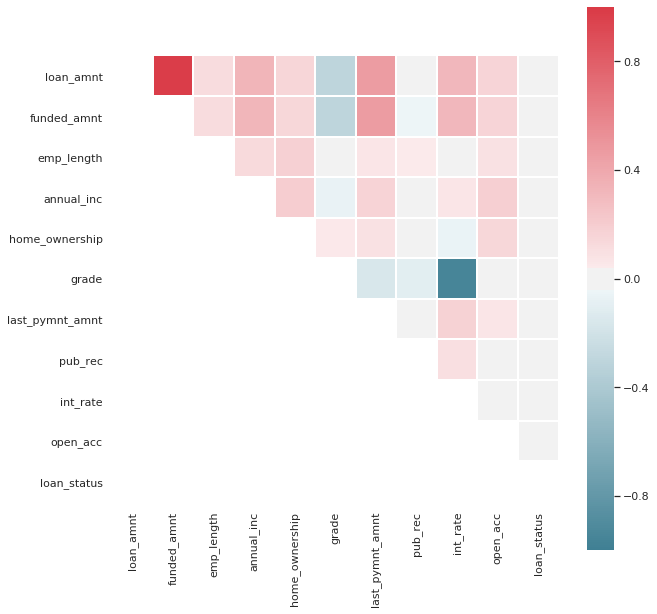

In [20]:
dataViz = data_clean
sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
corr = dataViz.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, ax=ax, mask=mask)

# Models


## Random Forest with randomized Search

<p>
<span style="color:blue">
Random forest when implemented with randomized search we got the best accuracies and minimum false negatives(predicting borowwer will not default eventhough he will. This might impact on the credibility of the company). We used the randomized search to find the best hyper paramters for the model.
</span>
</p>

In [21]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier(criterion='gini', random_state=0)
maxFeatures = range(1,data_clean.shape[1]-1)
param_dist = dict(max_features=maxFeatures)
rand = RandomizedSearchCV(rf, param_dist, cv=10, scoring='accuracy', n_iter=len(maxFeatures), random_state=10)
X=data_clean.iloc[:,:-1].values
y=data_clean.iloc[:,-1].values
rand.fit(X,y)

#print('Best Accuracy = '+str(rand.best_score_))
print(rand.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [22]:
randomForest = RandomForestClassifier(bootstrap=True,criterion = "gini",max_features=rand.best_estimator_.max_features,random_state=0 )
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfPredictproba = randomForest.predict_proba(X_test)[:,1] #for ROC curve
rfAccuracy = accuracy_score(y_test,rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print(rfAccuracy)

0.7031818181818181


## Feature Importance

Text(0, 0.5, 'Normalized Gini Importance')

findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.


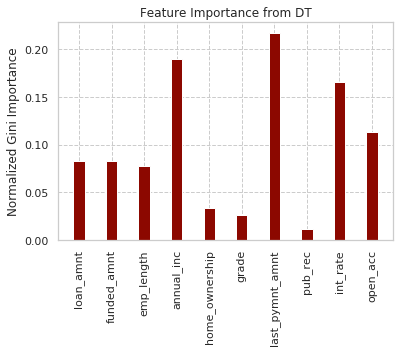

In [23]:
fig, ax = plt.subplots()
width=0.35
ax.bar(np.arange(len(features)-1), randomForest.feature_importances_, width, color='r')
ax.set_xticks(np.arange(len(randomForest.feature_importances_)))
ax.set_xticklabels(X_train.columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

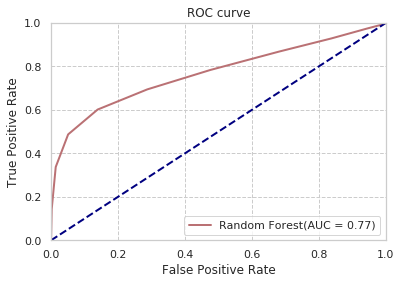

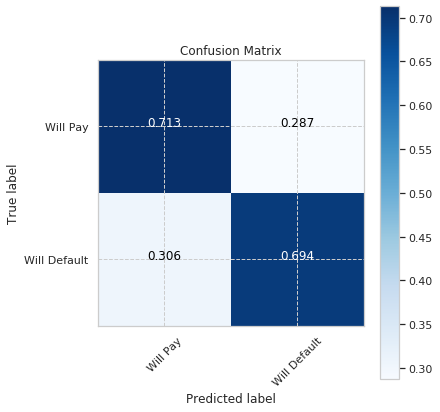

In [24]:
plotAUC(y_test,rfPredictproba, 'Random Forest')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(rfPredict, normalize=True)
plt.show()

## Precision,recall,F1score for all models

In [25]:
from sklearn.metrics import classification_report
print("RF",classification_report(y_test, rfPredict, target_names=None))




RF               precision    recall  f1-score   support

         0.0       0.69      0.71      0.70      1079
         1.0       0.72      0.69      0.70      1121

    accuracy                           0.70      2200
   macro avg       0.70      0.70      0.70      2200
weighted avg       0.70      0.70      0.70      2200

